In [1]:
%reload_ext autoreload
%autoreload

In [2]:
from imagenet_utils import *

Using TensorFlow backend.


In [3]:
import keras.backend as K
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D, Activation
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import keras
import pickle
import os
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [4]:
num_class = 100
index_to_label = pickle.load(open('index_to_label.p','rb'))
keep = pickle.load(open('keep100.p', 'rb'))
label_to_index = {index_to_label[keep[i]]:i for i in range(len(keep))}
index_to_label = {u:v for v,u in label_to_index.items()}

In [5]:
model = create_net('inception_100_weights_finetuneAll_2epochs.h5', num_class)

In [6]:
train_path = 'train100/'
val_path = 'val100/'
test_path = 'test100/'
classes = sorted(os.listdir(train_path))
num_imgs = [len(os.listdir(train_path+classes[c])) for c in range(num_class)]

In [7]:
convLayers = get_convLayers(model)
convBlocks = getBlocks(convLayers)

compute avg and std of all types of LCR used in Table 3 of the paper

In [1]:
#LOAD LCR
def load_LCR(dataset, method, gamma):
    train_pred = pickle.load(open(f'{dataset}_pred100.p', 'rb'))
    trainL = np.concatenate([[train_pred[c][i] != c for i in range(len(train_pred[c]))] for c in range(num_class)])
    train_pred = np.concatenate([train_pred[c] for c in range(num_class)])
    LCR_train = np.zeros(len(train_pred))
    p = 1
    for i in range(100):
        mutant_pred = pickle.load(open(f'{method}_{gamma}/{dataset}100/{p}_mutant{i}_0.002.p', 'rb'))
        LCR_train += mutant_pred != train_pred
    LCR_train = LCR_train/100
    return LCR_train, trainL

In [44]:
LCR_train, trainL = load_LCR('train', 'NAI', 0.002)
LCR_val, valL = load_LCR('val', 'NAI', 0.002)
LCR_test, testL = load_LCR('test', 'NAI', 0.002)

In [130]:
allLCR = np.concatenate((LCR_train, LCR_val, LCR_test))
allL = np.concatenate((trainL, valL, testL))

In [115]:
(np.mean(allLCR[allL == False]), np.std(allLCR[allL == False])) #NAI 0.0015

(0.05364918487354784, 0.11910676764710702)

In [116]:
(np.mean(allLCR[allL == True]), np.std(allLCR[allL == True]))

(0.3633458950201884, 0.22385765673249944)

In [107]:
(np.mean(allLCR[allL == False]), np.std(allLCR[allL == False])) #NAI 0.002

(0.07108540102946567, 0.13872897292925954)

In [108]:
(np.mean(allLCR[allL == True]), np.std(allLCR[allL == True]))

(0.41477792732166896, 0.2297071643857283)

In [123]:
(np.mean(allLCR[allL == False]), np.std(allLCR[allL == False])) #NAI 0.0025

(0.07987155583177959, 0.14947176700090387)

In [124]:
(np.mean(allLCR[allL == True]), np.std(allLCR[allL == True]))

(0.43205383580080753, 0.23589806021602852)

In [131]:
(np.mean(allLCR[allL == True]), np.std(allLCR[allL == True])) #GF 0.0015

(0.18452759084791387, 0.1830243501968797)

In [132]:
(np.mean(allLCR[allL == False]), np.std(allLCR[allL == False]))

(0.015556883555640546, 0.058829872043260054)

In [93]:
(np.mean(allLCR[allL == False]), np.std(allLCR[allL == False])) #GF 0.0025

(0.025461586269541522, 0.07633045987425406)

In [94]:
(np.mean(allLCR[allL == True]), np.std(allLCR[allL == True]))

(0.24501884253028264, 0.2061305194075611)

LCR performance with number of mutants used in figure 4 of the paper

In [45]:
val_pred = pickle.load(open('val_pred100.p', 'rb'))
valL = np.concatenate([[val_pred[c][i] != c for i in range(len(val_pred[c]))] for c in range(num_class)])
val_pred = np.concatenate([val_pred[c] for c in range(num_class)])
aurocs = []
for limit in range(10,101):
    LCR = np.zeros(len(val_pred))
    for i in range(limit):
        mutant_pred = pickle.load(open('NAI_0.002/val100/1_mutant'+str(i)+'_0.002.p', 'rb'))
        LCR += mutant_pred != val_pred
    LCR = LCR/limit
    threshs, ind, auroc = find_opti_thresh(valL, LCR, plot = False)
    aurocs.append(auroc)

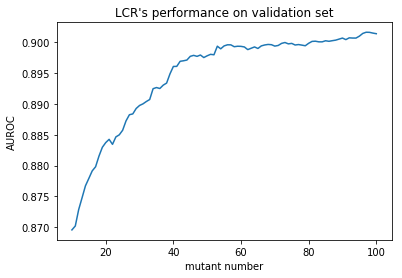

In [46]:
plt.plot(np.arange(10,101), aurocs)
plt.ylabel('AUROC')
plt.xlabel('mutant number')
plt.title('LCR\'s performance on validation set')
plt.savefig('LCR_mn.pdf', bbox_inches = 'tight')

Sorting LCR in the same order than conductance

In [129]:
wrongs_ind = pickle.load(open('imagenet100/wrongs100_ind.p', 'rb'))
L_wrong = []
for c in sorted(wrongs.keys()):
    for i in range(len(wrongs_ind[c])):
        ind = int(np.sum(num_imgs[:wrongs_ind[c][i][0]]) + wrongs_ind[c][i][1])
        L_wrong.append(ind)

In [130]:
rights_ind = pickle.load(open('imagenet100/rights100_ind.p', 'rb'))
for c in sorted(rights_ind.keys()):
    rights_ind[c] = [(c,ind) for ind in rights_ind[c]]
L_right = []
for c in sorted(rights.keys()):
    for i in range(len(rights_ind[c])):
        ind = int(np.sum(num_imgs[:rights_ind[c][i][0]]) + rights_ind[c][i][1])
        L_right.append(ind)

In [131]:
LCRW = LCR_train[L_wrong]
LCRR = LCR_train[L_right]
LCR_train = np.concatenate((LCRW, LCRR))
LCR_train.shape

(112932,)

In [135]:
pickle.dump(LCR_train, open('train100_LCR_NAI_0.002.p', 'wb'))
pickle.dump(LCR_val, open('val100_LCR_NAI_0.002.p', 'wb'))
pickle.dump(LCR_test, open('test100_LCR_NAI_0.002.p', 'wb'))

Loading Conductance

In [55]:
wrongs = pickle.load(open('cond_wrongs100.p', 'rb'))
rights = pickle.load(open('cond_rights100.p', 'rb'))

In [57]:
layers = [len(convLayers)-i-1 for i in range(len(convLayers))]
concat = 0
finalWrongs = process_data(layers, wrongs, concat)
finalRights = process_data(layers, rights, concat)

In [58]:
trainD = np.concatenate((finalWrongs, finalRights), axis = 0)

mean = np.mean(trainD, axis = 0)
ma = np.max(trainD, axis = 0)
mi = np.min(trainD, axis = 0)
trainD = (trainD - mean)/(ma-mi)
#trainD = np.concatenate((trainD, LCR_train.reshape((-1,1))), axis = 1)
y_wrongs = np.ones(len(finalWrongs))
y_rights = np.zeros(len(finalRights))
trainL = np.concatenate((y_wrongs, y_rights), axis = 0)

TRAINING

In [59]:
val_cond = pickle.load(open('cond_val100.p', 'rb'))
val_index = pickle.load(open('imagenet100/originIndex_val100.p', 'rb'))

In [62]:
valL = get_labels(val_index, 150, 'val_pred100', num_class)

In [63]:
valD = process_data(layers, val_cond, concat)
valD = (valD-mean)/(ma-mi)

In [66]:
verif = create_verif(trainD.shape[1])

In [31]:
roc_call = roc_callback(training_data=(trainD, trainL),validation_data=(valD, valL))
verif.fit(trainD, trainL, batch_size = 100, validation_data = (valD, valL), epochs = 10, callbacks = [roc_call])

Train on 112932 samples, validate on 15000 samples
Epoch 1/10
112932/112932 [==============================] - 12s 104us/step - loss: 0.1217 - val_loss: 0.1973
roc-auc: 0.95867 - roc-auc_val: 0.92675                                                                                                    
Epoch 2/10
112932/112932 [==============================] - 9s 80us/step - loss: 0.1001 - val_loss: 0.1777
roc-auc: 0.96726 - roc-auc_val: 0.93229                                                                                                    
Epoch 3/10
112932/112932 [==============================] - 10s 85us/step - loss: 0.0935 - val_loss: 0.1913
roc-auc: 0.97219 - roc-auc_val: 0.93317                                                                                                    
Epoch 4/10
112932/112932 [==============================] - 9s 83us/step - loss: 0.0875 - val_loss: 0.1841
roc-auc: 0.97524 - roc-auc_val: 0.93697                                                           

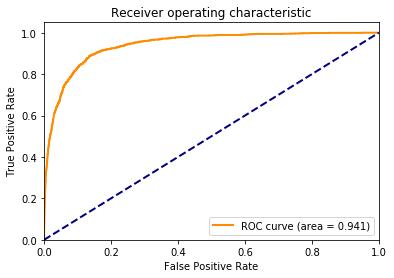

accuracy 0.873 mean recall 0.872871326304868 right recall 0.8730286804078339 wrong recall 0.8727139722019019
0.04 0.9409638796004209


In [69]:
val_res = verif.predict(valD)
cond_threshs, cond_ind, cond_auroc = find_opti_thresh(valL, val_res, plot = True)
cond_thresh = cond_threshs[cond_ind-35]
cond_thresh = 4.0e-2
_ = report_acc(val_res, valL, cond_thresh, True)
print(cond_thresh, cond_auroc)

In [249]:
#verif.save('best_cond100_nowbce.h5')

In [68]:
verif.load_weights('best_cond100_nowbce.h5')

TEST PART

In [70]:
test_cond2 = pickle.load(open('cond_test100.p', 'rb')) #calculated with one Grad
test_index = pickle.load(open('imagenet100/originIndex_test100.p', 'rb'))

In [71]:
testD = process_data(layers, test_cond2, concat = concat)
testD = (testD-mean)/(ma-mi)
#testD = np.concatenate((testD, LCR_test.reshape((-1,1))), axis = 1)

In [72]:
L = []
for c in sorted(rights.keys()):
    for i in range(len(test_index[c])):
        L.append(test_index[c][i][0]*50 + test_index[c][i][1])
#LCR_test = LCR_test[L]

In [73]:
test_pred = pickle.load(open('test_pred100.p', 'rb'))
ground_truth = np.array([[c for i in range(len(test_pred[c]))] for c in range(100)])
test_pred = np.array([test_pred[c] for c in range(100)]).reshape((1,-1))[0]
ground_truth = ground_truth.reshape((1,-1))[0]
test_labels = test_pred != ground_truth
test_labels = test_labels[L]

In [74]:
testL = test_labels

In [75]:
test_res = verif.predict(testD)
_ = report_acc(test_res, testL, cond_thresh, True)

accuracy 0.852 mean recall 0.8711090533513783 right recall 0.8465346534653465 wrong recall 0.89568345323741


LCR

In [76]:
LCR_train = pickle.load(open('train100_LCR_NAI_0.002.p', 'rb'))
LCR_val = pickle.load(open('val100_LCR_NAI_0.002.p', 'rb'))
LCR_test = pickle.load(open('test100_LCR_NAI_0.002.p', 'rb'))

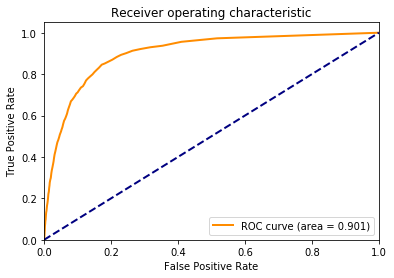

accuracy 0.8356 mean recall 0.8335381932615311 right recall 0.8360595613584684 wrong recall 0.831016825164594
0.0434 0.9014216118200646


In [77]:
lcr_threshs, lcr_ind, lcr_auroc = find_opti_thresh(valL, LCR_val, plot = True)
lcr_thresh = lcr_threshs[lcr_ind]
lcr_thresh = 4.34e-2
_ = report_acc(LCR_val, valL, lcr_thresh, True)
print(lcr_thresh, lcr_auroc)

In [78]:
_ = report_acc(LCR_test, testL, lcr_thresh, True)

accuracy 0.8166 mean recall 0.8338856367651153 right recall 0.8116561656165616 wrong recall 0.8561151079136691


LCR & COND

In [79]:
train_res = verif.predict(trainD)
train_res.shape

(112932, 1)

In [82]:
data = np.concatenate((LCR_train.reshape((-1,1)), train_res), axis = 1)
data_val = np.concatenate((LCR_val.reshape((-1,1)), val_res), axis = 1)
data_test = np.concatenate((LCR_test.reshape((-1,1)), test_res), axis = 1)

In [83]:
nn = Sequential()    
nn.add(Dense(10, input_shape = (data.shape[1],), activation = 'relu'))
nn.add(Dense(10, activation = 'relu'))
nn.add(Dropout(0.5))
nn.add(Dense(1, activation = 'sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
nn.compile(loss = 'binary_crossentropy', optimizer=opt,metrics=None)

In [183]:
roc_call = roc_callback(training_data=(data, trainL),validation_data=(data_val, valL))
history = nn.fit(data, trainL, validation_data = (data_val, valL), batch_size = 100, epochs = 1, callbacks = [roc_call])

Train on 112932 samples, validate on 15000 samples
Epoch 1/1
112932/112932 [==============================] - 6s 52us/step - loss: 0.0863 - val_loss: 0.1788
roc-auc: 0.98258 - roc-auc_val: 0.94581                                                                                                    


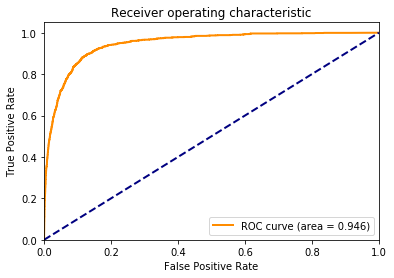

accuracy 0.8818 mean recall 0.8816615852783312 right recall 0.8818308516100638 wrong recall 0.8814923189465984
0.0091 0.9459067838050138


In [85]:
nn_val_res = nn.predict(data_val)
both_threshs, both_ind, both_auroc = find_opti_thresh(valL, nn_val_res, plot = True)
both_thresh = both_threshs[both_ind-12]
both_thresh = 9.1e-3
# both_thresh = 0.4
# both_thresh = 9.e-4
_ = report_acc(nn_val_res, valL, both_thresh, True)
print(both_thresh, both_auroc)

In [86]:
nn_test_res = nn.predict(data_test)
_ = report_acc(nn_test_res, testL, both_thresh, True)

accuracy 0.8618 mean recall 0.8742617966832655 right recall 0.8582358235823583 wrong recall 0.8902877697841727


In [70]:
def plot_confusion_matrix(y_true, y_pred, classes_name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes_name
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]       

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.tick_params(axis='both', which='minor', labelsize=9)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('test_cm.pdf', bbox_inches = 'tight')
    return ax

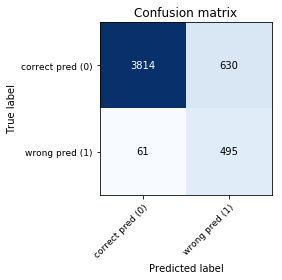

In [71]:
plot_confusion_matrix(testL, nn_test_res > both_thresh, classes_name = ['correct pred (0)', 'wrong pred (1)'])

In [182]:
#nn.save('best_no_wbce.h5')

In [84]:
nn.load_weights('best_no_wbce.h5')

In [87]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
cond_fpr, cond_tpr, cond_threshs = roc_curve(valL, val_res)
lcr_fpr, lcr_tpr, lcr_threshs = roc_curve(valL, LCR_val)
both_fpr, both_tpr, both_threshs = roc_curve(valL, nn_val_res)

In [88]:
both_x, both_y = both_fpr[both_ind-12], both_tpr[both_ind-12]
lcr_x, lcr_y = lcr_fpr[lcr_ind], lcr_tpr[lcr_ind]
cond_x, cond_y = cond_fpr[cond_ind-35], cond_tpr[cond_ind-35]

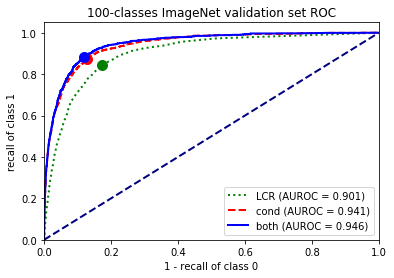

In [90]:
plt.figure()
lw = 2
plt.plot(lcr_fpr, lcr_tpr, ':', color = 'green',
         lw=lw, label='LCR (AUROC = %0.3f)' % lcr_auroc)
plt.plot(lcr_x, lcr_y,marker='o',  markersize=10, color= 'green')
plt.plot(cond_fpr, cond_tpr, '--', color = 'red',
         lw=lw, label='cond (AUROC = %0.3f)' % cond_auroc)
plt.plot(cond_x, cond_y, marker='o',  markersize=10, color= 'red')
plt.plot(both_fpr, both_tpr, color = 'blue',
         lw=lw, label='both (AUROC = %0.3f)' % both_auroc)
plt.plot(both_x, both_y, marker='o',  markersize=10, color= 'blue')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - recall of class 0')
plt.ylabel('recall of class 1')
plt.title('100-classes ImageNet validation set ROC')
plt.legend(loc="lower right")
plt.savefig('100Imagenet_ROC.pdf', bbox_inches = 'tight')
#plt.show()

In [209]:
#random forrest
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators = 100, max_depth=10 ,random_state=0)
clf_RF.fit(data, trainL)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

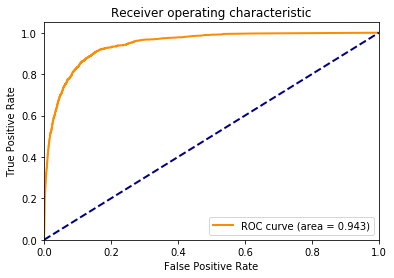

0.0243 0.9433457619375424
accuracy 0.8749333333333333 mean recall 0.8749221881948632 right recall 0.8749358175016504 wrong recall 0.8749085588880761


In [225]:
rf_val_res = clf_RF.predict_proba(data_val)[:,1]
threshs, ind, auroc = find_opti_thresh(valL, rf_val_res, plot = True)
thresh = threshs[ind-170]
thresh = 2.43e-2
print(thresh, auroc)
_ = report_acc(rf_val_res, valL, thresh, True)

In [227]:
rf_test_res = clf_RF.predict_proba(data_test)[:,1]
_ = report_acc(rf_test_res, testL, thresh, True)

accuracy 0.8534 mean recall 0.8750437094069119 right recall 0.8472097209720972 wrong recall 0.9028776978417267


In [226]:
#LDA & QDA

In [230]:
#LDA & QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
clf_LDA = LDA()
clf_QDA = QDA()
clf_LDA.fit(data, trainL)
clf_QDA.fit(data, trainL)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

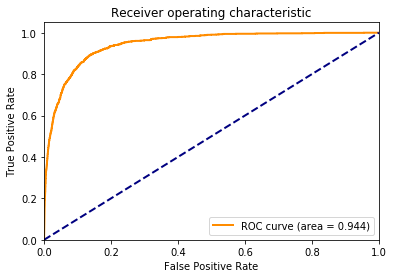

6.22e-09 0.9439670490581533
accuracy 0.8752 mean recall 0.8750688910482337 right recall 0.8752292232083914 wrong recall 0.8749085588880761


In [236]:
LDA_val_res = clf_LDA.predict_proba(data_val)[:,1]
threshs, ind, auroc = find_opti_thresh(valL, LDA_val_res, plot = True)
thresh = threshs[ind-50]
thresh = 6.22e-9
print(thresh, auroc)
_ = report_acc(LDA_val_res, valL, thresh, True)

In [238]:
LDA_test_res = clf_LDA.predict_proba(data_test)[:,1]
_ = report_acc(LDA_test_res, testL, thresh, True)

accuracy 0.8542 mean recall 0.8715599077893401 right recall 0.8492349234923492 wrong recall 0.8938848920863309


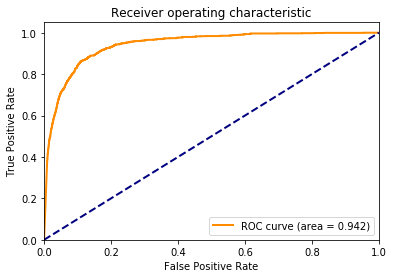

0.00602 <function auc at 0x000001FFB0CE18C8>
accuracy 0.8738666666666667 mean recall 0.8733481105783221 right recall 0.8739822489547422 wrong recall 0.8727139722019019


In [245]:
QDA_val_res = clf_QDA.predict_proba(data_val)[:,1]
threshs, ind, auroc = find_opti_thresh(valL, QDA_val_res, plot = True)
thresh = threshs[ind+20]
thresh = 6.02e-3
print(thresh, auc)
_ = report_acc(QDA_val_res, valL, thresh, True)

In [246]:
test_pred = clf_QDA.predict_proba(data_test)[:,1]
_ = report_acc(test_pred, testL, thresh, True)

accuracy 0.8562 mean recall 0.8711114816517623 right recall 0.851935193519352 wrong recall 0.8902877697841727
